In [1]:
import torch
# Imports
# ============================
import torch
import pandas as pd
import matplotlib.pyplot as plt

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


c:\Users\ARINDAM DAS\Desktop\spam trans\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Config
# ============================
MODEL_NAME = "distilbert-base-uncased"
MAX_LENGTH = 256
BATCH_SIZE = 16
EPOCHS = 3
LR = 2e-5

In [3]:
# Load CSV files
# ============================
train_df = pd.read_csv("train.csv")
val_df   = pd.read_csv("validation.csv")

In [4]:
# Expected columns:
# message -> email text
# label   -> "Spam" / "Not Spam"

label2id = {"Not Spam": 0, "Spam": 1}
id2label = {0: "Not Spam", 1: "Spam"}

train_df["label"] = train_df["label"].map(label2id)
val_df["label"]   = val_df["label"].map(label2id)

train_df = train_df.dropna(subset=["message", "label"])
val_df   = val_df.dropna(subset=["message", "label"])

In [5]:
# Convert to HF Dataset
# ============================
train_ds = Dataset.from_pandas(train_df, preserve_index=False)
val_ds   = Dataset.from_pandas(val_df, preserve_index=False)

In [6]:
# Tokenizer
# ============================
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(
        batch["message"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH
    )

train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize, batched=True)

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map: 100%|██████████| 10017/10017 [00:02<00:00, 4553.98 examples/s]


In [7]:
# Model
# ============================
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    label2id=label2id,
    id2label=id2label
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Metrics (Spam = positive)
# ============================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, pos_label=1),
        "recall": recall_score(labels, preds, pos_label=1),
        "f1": f1_score(labels, preds, pos_label=1),
    }


In [9]:
# Training Arguments
# ============================
training_args = TrainingArguments(
    output_dir="./distilbert-spam",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    learning_rate=LR,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2,
    report_to="none"
)

In [10]:
# Trainer
# ============================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


C:\Users\ARINDAM DAS\AppData\Local\Temp\ipykernel_2172\3623572400.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [11]:
# Train
# ============================
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.034200,0.047318,0.987821,0.992181,0.982218,0.987174
2,0.024300,0.032846,0.992113,0.989178,0.994351,0.991758
3,0.001200,0.041641,0.993012,0.992678,0.992678,0.992678


TrainOutput(global_step=15027, training_loss=0.034306022899767405, metrics={'train_runtime': 2932.2707, 'train_samples_per_second': 81.993, 'train_steps_per_second': 5.125, 'total_flos': 1.5924303394633728e+16, 'train_loss': 0.034306022899767405, 'epoch': 3.0})

In [12]:
model.save_pretrained("./bert-spam")
tokenizer.save_pretrained("./bert-spam")


('./bert-spam\\tokenizer_config.json',
 './bert-spam\\special_tokens_map.json',
 './bert-spam\\vocab.txt',
 './bert-spam\\added_tokens.json',
 './bert-spam\\tokenizer.json')

In [13]:
# Final Evaluation
# ============================
metrics = trainer.evaluate()
print("\nFinal Evaluation Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


Final Evaluation Metrics:
eval_loss: 0.0416
eval_accuracy: 0.9930
eval_precision: 0.9927
eval_recall: 0.9927
eval_f1: 0.9927
eval_runtime: 27.5868
eval_samples_per_second: 363.1080
eval_steps_per_second: 22.7280
epoch: 3.0000


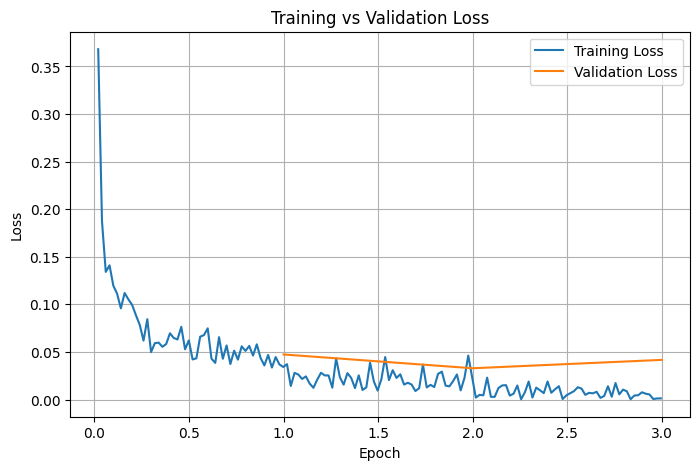

<Figure size 640x480 with 0 Axes>

In [14]:
# Plot Training vs Validation Loss
# ============================
log_history = trainer.state.log_history

train_loss = []
eval_loss = []
epochs_train = []
epochs_eval = []

for log in log_history:
    if "loss" in log and "epoch" in log and "eval_loss" not in log:
        train_loss.append(log["loss"])
        epochs_train.append(log["epoch"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        epochs_eval.append(log["epoch"])

plt.figure(figsize=(8, 5))
plt.plot(epochs_train, train_loss, label="Training Loss")
plt.plot(epochs_eval, eval_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Optional: save plot
plt.savefig("loss_curve.png", dpi=300, bbox_inches="tight")